In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
from PIL import Image
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2

In [19]:
# Ścieżki do folderów z danymi
folder_11 = "11"  # Pozytywna klasa, etykieta 1
folder_00 = "00"  # Negatywna klasa, etykieta 0

# Funkcja do wczytywania obrazów i wykrywania linii
def load_and_process_image(file_path):
    img = Image.open(file_path)
    img = img.convert("L")  # Konwersja obrazu do odcieni szarości
    img_array = np.array(img)

    # Wykrywanie linii na obrazie za pomocą algorytmu Hougha
    edges = canny(img_array, sigma=1.0, low_threshold=50, high_threshold=100)
    accumulator, angles, distances = hough_line(edges)
    peaks = hough_line_peaks(accumulator, angles, distances)

    if len(peaks) > 0:
        return resize(img_array, (180, 180)), 1  # Jeśli znaleziono linie, to etykieta 1
    else:
        return resize(img_array, (180, 180)), 0  # Jeśli nie znaleziono linii, to etykieta 0

# Listy przechowujące obrazy i etykiety
all_images = []
all_labels = []

# Wczytaj obrazy z foldera "11" i przypisz im etykietę 1
for filename in os.listdir(folder_11):
    if filename.endswith(".png"):
        image_path = os.path.join(folder_11, filename)
        image, label = load_and_process_image(image_path)
        all_images.append(image)
        all_labels.append(label)

# Wczytaj obrazy z foldera "00" i przypisz im etykietę 0
for filename in os.listdir(folder_00):
    if filename.endswith(".png"):
        image_path = os.path.join(folder_00, filename)
        image, label = load_and_process_image(image_path)
        all_images.append(image)
        all_labels.append(label)

# Konwersja list na tablice NumPy
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Przygotowanie datasetu
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))

# Wymieszanie i podzielenie datasetu na zbiór treningowy i walidacyjny
buffer_size = 1000  # Wartość większa niż zero
dataset = dataset.shuffle(buffer_size=buffer_size).batch(128)
train_size = int(0.8 * len(all_images))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Definicja modelu
model = keras.Sequential([
    layers.Flatten(input_shape=(180, 180)),  # Rozmiar dostosowany do obrazów
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Model klasyfikacji binarnej
])

# Kompilacja modelu
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Funkcja straty dla klasyfikacji binarnej
              metrics=['accuracy'])

# Trenowanie modelu
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
1/1 [==============================] - 0s 323ms/step - loss: 0.4544 - accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 1.0792e-26 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy:

1/1 [==============================] - 0s 15ms/step
Na obrazie jest zaliczona działalność ludzka (etykieta 1).


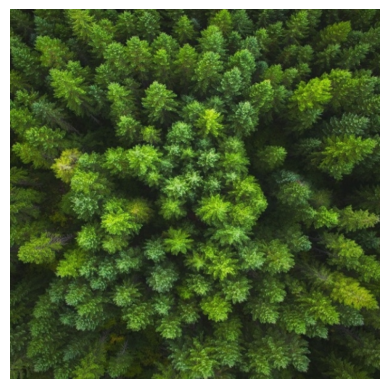

1.0


In [30]:
def process_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (180, 180))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image
#-------------------------------Ścieżka do obrazu-----------------------------------#
image_path = '1.png'
#-----------------------------------------------------------------------------------#

image = process_image(image_path)
dane_obrazu = np.array(image)

# Wykonanie analizy widmowej Fouriera nowego obrazu
widmo = np.fft.fftshift(np.fft.fft2(dane_obrazu))
widmo_amp = np.abs(widmo)

IG = np.log(1 + widmo_amp)

prediction = model.predict(IG)

if prediction[0][0] >= 0.5:
    print("Na obrazie jest zaliczona działalność ludzka (etykieta 1).")
else:
    print("Na obrazie nie ma zaliczonej działalności ludzkiej (etykieta 0).")


original_image = cv2.imread(image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image_rgb)
plt.axis('off')
plt.show()
print(prediction[0][0])